<h1>Simulation of QKD Protocol</h1>

This project implements the BB84 quantum key distribution protocol for secure key exchange. It includes encryption and decryption functions for message security. Various potential Eve Eyes attacks are also addressed to ensure robustness.

In [1]:
# !pip install cirq

In [2]:
import cirq
import random
import numpy as np
from cirq import X,H,Z,I

<h3>Constants</h3>

In [3]:
k=None
toBinary= lambda x,size:bin(x)[2:].zfill(size)
toDecimal= lambda binary_num: int(binary_num, 2)
qubits=None
alicekey=None
message=None
circuit=None

# Helper Functions

This getKey function generate a random number between *2 to $2^k - 1$*. This number is used to encrypt the **Alice Message** and the key would be send through **Quantum Channel**.

In [4]:
def getKey(size):
  global k
  k=size
  key=random.randint(2, 2**k-1)
  alicekey=toBinary(key,k)
  return key

encodeKeyToQubit would change the bit to the qubit state. Example **0010** to **|0010>**

In [5]:
def encodeKeyToQubit(key):
  global qubits
  global k
  circuit=cirq.Circuit()
  qubits=cirq.NamedQubit.range(k,prefix='q')
  for i,bit in enumerate(key):
    if bit =='1':
      circuit.append(X.on(qubits[i]))
  return circuit

The following function is used to generate random basis operations on qubits in Quantum Key Distribution (QKD). By randomly choosing between the computational (Z) and Fourier (X) bases, this function ensures the security of key generation through quantum uncertainty.

In [6]:
def getRandomBasis():
  global k
  gates = [X ,H, X, X, H ,H, X , X , H, H, X, X, H ,H, X , X , H, H, X, H, X]
  random_gates = [random.choice(gates) for _ in range(k)]  # Generating a list of k random gates
  return random_gates

# Encrypting and Decrypting Message

### Private Key Method:

- The private key in this algorithm is the integer used to shift the characters during encryption and decryption.
- The key is kept secret between the communicating parties and is essential for decrypting the message.
- To decrypt the message successfully, the recipient needs to know the exact key used by the sender during encryption.

This code implements a basic Caesar cipher encryption and decryption algorithm. Here's how it works:

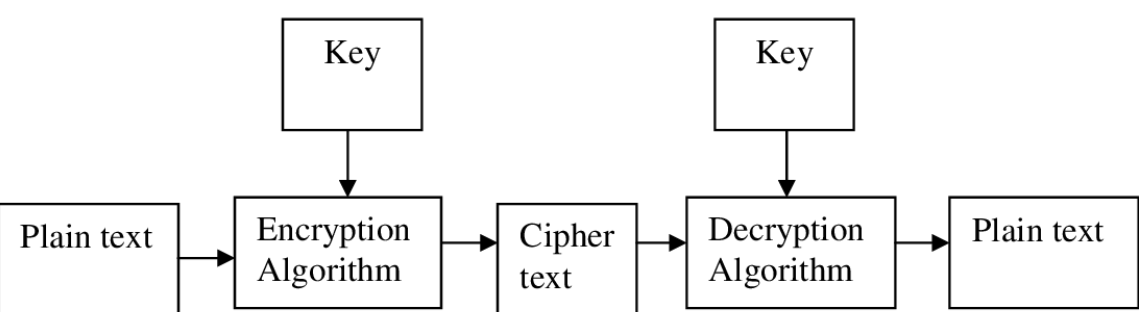

### Algorithm:

1. **<h1>Encryption (encrypt function)</h1>**

   - Take the input text and a key (an integer representing the number of positions to shift each character).
   - Initialize an empty string for the encrypted text.
   - For each character in the input text:
     - Shift the character by the key value.
     - Ensure that the shifted character remains within the range of alphabets (both lowercase and uppercase).
     - Append the shifted character to the encrypted text.
   - Return the encrypted text.


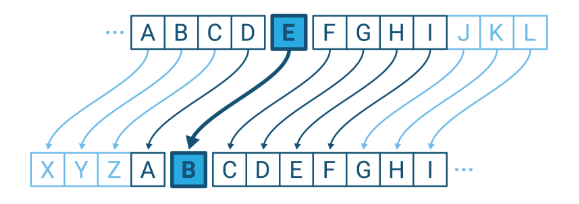


2. **<h1>Decryption (decrypt function)</h1>**

   - The decryption function is essentially the same as the encryption function, except it calls the encryption function with an additional argument `decrypt=True`.
   - This ensures that the characters are shifted in the opposite direction during decryption.


In [7]:
def encrypt(text, key,decrypt=False):
    encrypted_text = ""
    key = key % 26
    if decrypt:
      key=-1*key
    for char in text:
          shifted = ord(f'{char}') + key
          if char.islower():
              if shifted > ord('z'):
                  shifted -= 26
              elif shifted < ord('a'):
                  shifted += 26
          elif char.isupper():
              if shifted > ord('Z'):
                  shifted -= 26
              elif shifted < ord('A'):
                  shifted += 26
          encrypted_text += chr(shifted)
    return encrypted_text

def decrypt(encrypted_text, key):
    return encrypt(encrypted_text,key,decrypt=True)


<h2>EveEyes Attack </h2>


### 1. `interceptAndSend(circuit)`:
   - **What happens**: This function simulates an eavesdropper intercepting qubits being transmitted in a quantum communication channel.
   - **Details**:
     - It measures the qubits in the circuit and stores the measurement results.
     - These measurement results represent the intercepted information.
     - After obtaining the measurement results, the eavesdropper encodes the qubits based on their measurement.
   

### 2. `entangleQubit(circuit)`:
   - **What happens**: This function entangles additional qubits controlled by the original qubits in the quantum circuit.
   - **Details**:
     - It creates a set of qubits for the eavesdropper.
     - For each qubit in the original set, it entangles it with a corresponding qubit from the eavesdropper's set.
  

### Summary:
- `interceptAndSend(circuit)` allows an eavesdropper to intercept qubits by measuring them and then encoding them based on the measurement results.
- `entangleQubit(circuit)` lets an eavesdropper entangle their own qubits with the transmitted qubits.

In [8]:
def interceptAndSend(circuit):
  circuit.append(cirq.measure(*qubits,key="EVE"))
  sim=cirq.Simulator()
  results=sim.run(circuit,repetitions=1)
  measurement_results = results.measurements['EVE']
  key=''
  for outcomes in measurement_results[0]:
    key+=str(outcomes)
  return key


def entangleQubit(circuit):
  global k
  eveQubits=cirq.NamedQubit.range(k,prefix="EVE")
  circuit.append(cirq.H.on_each(*qubits))
  for i in range(k):
    circuit.append(cirq.X(eveQubits[i]).controlled_by(qubits[i]))

  circuit.append(cirq.H.on_each(*qubits))


<h2>Key Distribution Protocol</h2>

This function, `applyBasis`, constructs a quantum circuit based on the specified basis operations.
It iterates through each qubit and applies the corresponding basis operation (e.g., Pauli X or Z gate) according to the provided basis list.
The resulting circuit incorporates the basis operations applied to each qubit, ready for further quantum operations or measurements.

In [9]:
def applyBasis(basis):
  global qubits
  circuit=cirq.Circuit()
  for bas,qubit in zip(basis,qubits):
    circuit=circuit+ bas.on(qubit)
  return circuit

This function, `getBobKey`, retrieves the key generated by Bob after measuring the qubits in the provided quantum circuit..
Aftemeasuringit and obtaining the measurement results, it constructs and returns the key based on the outcomes of the measurements.

In [10]:
def getBobKey(circuit):
  print(".....Receiving Key....")
  key=''
  circuit.append(cirq.measure(*qubits,key='bob'))
  sim=cirq.Simulator()
  results=sim.run(circuit,repetitions=1)
  measurement_results = results.measurements['bob']
  for outcomes in measurement_results[0]:
    key+=str(outcomes)
  print(".....Received Key....")
  return key

<h3>The Most Important Part Of QKD BB84</h3>

This function, `checkEveEye`, is designed to detect a potential eavesdropper (Eve) in the quantum communication channel by identifying discrepancies between the keys measured by Bob and the original key generated by Alice.

### Explanation:

1. **Inputs**:
   - `measuredKey`: The key obtained by Bob after measuring the qubits.
   - `alicebasis`: The basis used by Alice to encode her qubits.
   - `bobbasis`: The basis used by Bob to measure the qubits.

2. **Process**:
   - It iterates through each qubit's index to compare the bases used by Alice and Bob.
   - If the bases match for a particular qubit, their indices are added to `matched_basis`.
   - Then, for each index in `matched_basis`, it checks if the corresponding qubits in Alice's and Bob's keys match. If they don't, it indicates a potential eavesdropper.
   - If a discrepancy is found, it returns `True` along with the indices of matched bases.
   - If no discrepancies are found, it returns `False` along with the indices of matched bases.

3. **Output**:
   - If a discrepancy is detected, it returns `True` along with the indices of matched bases where the discrepancy occurred.
   - If no discrepancy is detected, it returns `False` along with the indices of matched bases.

### Example:
Suppose Alice and Bob agree to use the same basis (e.g., both use the Z basis). If Eve tries to intercept and measure the qubits, she might introduce errors. This function identifies such discrepancies by comparing Alice's original key with the key obtained by Bob. If they don't match, it suggests the presence of an eavesdropper.

In [11]:
def checkEveEye(measuredKey,alicebasis,bobbasis):
  global alicekey
  matched_basis=[]
  print(".....Checking Eve Eye Attack......\n")
  for i in range(len(alicebasis)):
      if alicebasis[i]==bobbasis[i]:
        matched_basis.append(i)

  for index in matched_basis:
    if measuredKey[index]==alicekey[index]:
      continue
    else:
      return True,matched_basis

  return False,matched_basis

<h1>Simulation Of The Protocol</h1>

<h2>With NO EVE-EYES Key Distribution</h2>

In [12]:
key=getKey(199)
receivedKey=['0' for i in range(k)] #intermediate key
finalBobKey={}
aliceMesage="Hey whats up let have suprise party at Black House"
aliceMesage=encrypt(aliceMesage,key)
print("Sending ",aliceMesage)
print(key)
alicekey=toBinary(key,k)
while len(finalBobKey) != k:
    circuit=cirq.Circuit()
    circuit=circuit + encodeKeyToQubit(alicekey)
    alicebasis=getRandomBasis()
    bobbasis=getRandomBasis()
    circuit+=applyBasis(alicebasis)#alice basis
    #########################################################

    #########################################################
    circuit+=applyBasis(bobbasis)#alice basis
    bobKey=getBobKey(circuit)
    hasEveEye,matchedkey= checkEveEye(bobKey,alicebasis,bobbasis)
    if hasEveEye:
      print('..................Eve Eye Detected..................Boom!!!!!!')
      break
    else:
      for index in matchedkey:
        finalBobKey[index]=bobKey[index]

if(len(finalBobKey) == k):
  print("No eve Eye Detected. Message is completely secured\n")
  for key,value in finalBobKey.items():
    index = int(key)
    receivedKey[index]=value
  receivedKey=toDecimal(''.join(receivedKey))
  print("Received Key: ",receivedKey)
  received_message=decrypt(aliceMesage,receivedKey)
  print("\nMessage: ",received_message)

Sending  Zwq2ozslk2mh2dwl2zsnw2kmhjakw2hsjlq2sl2Tdsuc2Zgmkw
736214245290847705240791962258926867441333166023833491392274
.....Receiving Key....
.....Received Key....
.....Checking Eve Eye Attack......

.....Receiving Key....
.....Received Key....
.....Checking Eve Eye Attack......

.....Receiving Key....
.....Received Key....
.....Checking Eve Eye Attack......

.....Receiving Key....
.....Received Key....
.....Checking Eve Eye Attack......

.....Receiving Key....
.....Received Key....
.....Checking Eve Eye Attack......

.....Receiving Key....
.....Received Key....
.....Checking Eve Eye Attack......

.....Receiving Key....
.....Received Key....
.....Checking Eve Eye Attack......

No eve Eye Detected. Message is completely secured

Received Key:  736214245290847705240791962258926867441333166023833491392274

Message:  Hey whats up let have suprise party at Black House


<h2>With Entanglement of Qubit by eveEyes</h2> 

In [13]:
key=getKey(10)
receivedKey=['0' for i in range(k)] #intermediate key
finalBobKey={}
aliceMesage="Hey whats up let have suprise party at Black House"
aliceMesage=encrypt(aliceMesage,key)
print("Sending ",aliceMesage)
print(key)
alicekey=toBinary(key,k)
while len(finalBobKey) != k:
    circuit=cirq.Circuit()
    circuit=circuit + encodeKeyToQubit(alicekey)
    alicebasis=getRandomBasis()
    bobbasis=getRandomBasis()
    circuit+=applyBasis(alicebasis)#alice basis
    #########################################################
    entangleQubit(circuit)
    #########################################################
    circuit+=applyBasis(bobbasis)#alice basis
    bobKey=getBobKey(circuit)
    print(circuit)
    hasEveEye,matchedkey= checkEveEye(bobKey,alicebasis,bobbasis)
    if hasEveEye:
      print('..................Eve Eye Detected..................Boom!!!!!!')
      break
    else:
      for index in matchedkey:
        finalBobKey[index]=bobKey[index]

if(len(finalBobKey) == k):
  print("No eve Eye Detected. Message is completely secured\n")
  for key,value in finalBobKey.items():
    index = int(key)
    receivedKey[index]=value
  receivedKey=toDecimal(''.join(receivedKey))
  print("Received Key: ",receivedKey)
  received_message=decrypt(aliceMesage,receivedKey)
  print("\nMessage: ",received_message)

Sending  Axr3patml3ni3exm3atox3lnikblx3itkmr3tm3Uetvd3Ahnlx
201
.....Receiving Key....
.....Received Key....
                     ┌──────────┐
EVE0: ────────────────X────────────────────────────────
                      │
EVE1: ────────────────┼X───────────────────────────────
                      ││
EVE2: ────────────────┼┼X──────────────────────────────
                      │││
EVE3: ────────────────┼┼┼X─────────────────────────────
                      ││││
EVE4: ────────────────┼┼┼┼X────────────────────────────
                      │││││
EVE5: ────────────────┼┼┼┼┼X───────────────────────────
                      ││││││
EVE6: ────────────────┼┼┼┼┼┼X──────────────────────────
                      │││││││
EVE7: ────────────────┼┼┼┼┼┼┼X─────────────────────────
                      ││││││││
EVE8: ────────────────┼┼┼┼┼┼┼┼X────────────────────────
                      │││││││││
EVE9: ────────────────┼┼┼┼┼┼┼┼┼X───────────────────────
                      ││││││││││
q0: ────────

<h2>With Intercept and Resend Attack</h2>

In [14]:
key=getKey(10)
receivedKey=['0' for i in range(k)] #intermediate key
finalBobKey={}
aliceMesage="Hey whats up let have suprise party at Black House"
aliceMesage=encrypt(aliceMesage,key)
print("Sending ",aliceMesage)
print(key)
alicekey=toBinary(key,k)
while len(finalBobKey) != k:
    circuit=cirq.Circuit()
    circuit=circuit + encodeKeyToQubit(alicekey)
    alicebasis=getRandomBasis()
    bobbasis=getRandomBasis()
    circuit+=applyBasis(alicebasis)#alice basis
    #########################################################
    interceptKey=interceptAndSend(circuit)
    encodeKeyToQubit(interceptKey)
    #########################################################
    circuit+=applyBasis(bobbasis)#alice basis
    bobKey=getBobKey(circuit)
    print(circuit)
    hasEveEye,matchedkey= checkEveEye(bobKey,alicebasis,bobbasis)
    if hasEveEye:
      print('..................Eve Eye Detected..................Boom!!!!!!')
      break
    else:
      for index in matchedkey:
        finalBobKey[index]=bobKey[index]

if(len(finalBobKey) == k):
  print("No eve Eye Detected. Message is completely secured\n")
  for key,value in finalBobKey.items():
    index = int(key)
    receivedKey[index]=value
  receivedKey=toDecimal(''.join(receivedKey))
  print("Received Key: ",receivedKey)
  received_message=decrypt(aliceMesage,receivedKey)
  print("\nMessage: ",received_message)

Sending  Ifz!xibut!vq!mfu!ibwf!tvqsjtf!qbsuz!bu!Cmbdl!Ipvtf
833
.....Receiving Key....
.....Received Key....
q0: ───X───X───M('EVE')───X───M('bob')───
               │              │
q1: ───X───X───M──────────X───M──────────
               │              │
q2: ───────X───M──────────X───M──────────
               │              │
q3: ───X───X───M──────────H───M──────────
               │              │
q4: ───────H───M──────────X───M──────────
               │              │
q5: ───────X───M──────────X───M──────────
               │              │
q6: ───────X───M──────────X───M──────────
               │              │
q7: ───────X───M──────────X───M──────────
               │              │
q8: ───────H───M──────────X───M──────────
               │              │
q9: ───X───X───M──────────H───M──────────
.....Checking Eve Eye Attack......

.....Receiving Key....
.....Received Key....
q0: ───X───X───M('EVE')───H───M('bob')───
               │              │
q1: ───X───H───M──────────H─